In [1]:
# Initialization

import math
from datetime import datetime
import openpyxl as opxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model as ty
import proc as pr
import matplotlib.ticker as mtick
import sklearn.metrics

from IPython.core.display import HTML

import heat_transfer as bht

import fluids as fds
import ht 

import general as gen

import os

import scipy.integrate as integrate

In [2]:
# Crée un dictionnaire par et récupère les données du fichiers 'Inputs.xlsx' avec pd.read_excel
par = pr.create_par()

# Trouve le path pour le fichier d'outputs, crée un Excel avec openpyxl et les renvoie
pathout,wbo = pr.create_out()
sheet_o = wbo.active
sheet_o.title = "Inputs"
# Pour titre fichier outputs
moment = str(datetime.now().hour)+'-'+str(datetime.now().minute)+'-'+str(datetime.now().second)

# data = r'\220321_TUV_test_condi_output_outputtions.xlsx'
# data = r'\2205_TUV_test_conditions_V4.3.1.xlsx'
# data = r'\230104_TUV_test_conditions_V4.41_MPP_0flowrate.xlsx'
data = r'\230104_TUV_test_conditions_V4.41_MPP.xlsx'
# data = r'\condi_TSL.xlsx'
# data = r'\210914_TUV_test_conditions_SPRING.xlsx'

condi = pr.create_inputs_from_excel(data)

c:\Users\valen\Dropbox (DualSun)\PC\Documents\GitHub\PVT-perf-1Dmodel


In [ ]:
ty.change_air_layer(par,0.000)

In [ ]:
par["coeff_h_top_free"] = 2.5
par["coeff_h_top_forced"] = 2.
par["coeff_h_back"] = 2.5

In [3]:
df_par,df_res,X,list_df,list_df_historic = ty.simu_condi(par,condi)

df_res["S_loc"] = float(df_par.loc["W"])*float(df_par.loc["L_riser"])*df_res["S"]
df_res["-Q_fluid_back"] = -df_res["Q_fluid_back"]
# df_res["-Q_f01"] = -df_res["Q_f01"]

In [4]:
# Process condi

condi_output = condi.copy()

dict = {'ta':'T_amb','U':'u','mdot':'m_dot','tin':'T_fluid_in','te':'T_fluid_out','tm':'T_m'}

column_headers = list(condi_output.columns.values)

for i in range(len(column_headers)):
    head = column_headers[i]
    if head in list(dict.keys()):
        condi_output.rename(columns = {head:dict[head]}, inplace = True)

condi_output['Gp'] = 0.*condi_output['G']
condi_output['T_fluid_in'] = condi_output['T_fluid_in']+273.15
condi_output['T_fluid_out'] = condi_output['T_fluid_out']+273.15
condi_output['T_amb'] = condi_output['T_amb']+273.15

condi_output = condi_output.reset_index()

condi_output = condi_output.drop(columns=["index","Date","UTC"])

condi_output = condi_output.astype('float64')


In [5]:
SK_condi_output = ty.find_a_i(condi_output,par)
SK_df_res = ty.find_a_i(df_res,par)
pr.display_a_i(ty.find_a_i(condi_output,par))
pr.display_a_i(ty.find_a_i(df_res,par))

eta0,hem  :  0.396
a1  :  16.238
a2  :  0.0
a3  :  1.082
a4  :  0.0
a6  :  0.0
a7  :  0.013
a8  :  0.0
39.6 %
14.4
eta0,hem  :  0.408
a1  :  13.638
a2  :  -0.0
a3  :  1.14
a4  :  0.0
a6  :  0.0
a7  :  0.006
a8  :  0.0
40.8 %
11.7


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [5]:
pr.disp_html(df_res)
pr.display_a_i(X)

,G,-(T_m - T_a),-(T_m - T_a)^2,-up x (T_m - T_a),Gp,up x G,up x Gp,-(T_m - T_a)^4,m_dot,T_amb,u,h_top,h_back,h_fluid,T_PV,T_fluid_in,h_rad,X_celltemp,eta_PV,S,T_fluid_out,qp_fluid,T_fluid_mean,T_Base_mean,T_fin_mean,T_abs_mean,T_PV_meanB,qp_PV_Base,qp_Base_back,qp_fin,Q_top_conv,Q_top_rad,Q_PV_plate,Q_PV_Base,Q_Base_back,Q_fluid1,Q_fluid2,Q_absfins_Base,Q_fluid_back,DT,T_m,T_m en °C,c_p(T),Q_dot,Q_dot / A_G,S_loc,-Q_fluid_back
0,1002,1.522569,0.0,-3.501909,0.0,2304.6,9.2,-5.374128,0.05230,303.315,0.7,7.182077,2.566757,176.335902,304.835177,299.843,6.076580,0.977270,0.195454,644.924010,303.741862,2.120258,301.822005,302.824002,302.824002,302.824002,304.835177,2.107220,0.0,6.302810e-11,0.047109,0.024280,2.823674,2.823674,0.0,2.841145,2.841145,1.689153e-10,-0.017133,3.898862,301.792431,28.642431,4179.988961,852.343547,440.061887,2.895064,0.017133
1,1002,1.590508,0.0,-3.658167,0.0,2304.6,9.2,-6.399455,0.05229,303.407,0.7,7.167966,2.676232,176.335902,304.864108,299.863,6.080183,0.977172,0.195434,644.939779,303.769985,2.124264,301.846334,302.850225,302.850225,302.850225,304.864108,2.110057,0.0,6.313578e-11,0.045070,0.022589,2.827476,2.827476,0.0,2.846514,2.846514,1.692039e-10,-0.018670,3.906985,301.816492,28.666492,4179.980596,853.954308,440.893517,2.895135,0.018670
2,1002,0.750871,0.0,-0.675784,0.0,901.8,3.6,-0.317879,0.05234,302.512,2.1,12.005943,1.744920,176.335902,304.716210,299.878,6.049191,0.977675,0.195535,644.859163,303.644258,2.049717,301.795347,302.764008,302.764008,302.764008,304.716210,2.045431,0.0,6.101367e-11,0.111285,0.042610,2.740878,2.740878,0.0,2.746621,2.746621,1.635166e-10,-0.005598,3.766258,301.761129,28.611129,4179.999882,823.986319,425.421153,2.894773,0.005598
3,1002,0.789271,0.0,-0.710344,0.0,901.8,3.6,-0.388064,0.05235,302.556,2.1,12.003085,1.677044,176.335902,304.724693,299.882,6.050748,0.977646,0.195529,644.863787,303.651459,2.051850,301.800838,302.770507,302.770507,302.770507,304.724693,2.047509,0.0,6.108371e-11,0.109468,0.041663,2.743662,2.743662,0.0,2.749479,2.749479,1.637043e-10,-0.005670,3.769459,301.766729,28.616729,4179.997925,824.843849,425.863892,2.894794,0.005670
4,1002,0.119358,0.0,0.107422,0.0,-901.8,-3.6,-0.000203,0.05236,301.791,3.9,19.182341,2.356473,176.335902,304.512062,299.871,6.021779,0.978369,0.195674,644.747884,303.472285,1.960698,301.714732,302.641324,302.641324,302.641324,304.512062,1.960077,0.0,5.830939e-11,0.211505,0.056265,2.626503,2.626503,0.0,2.627335,2.627335,1.562692e-10,-0.000804,3.601285,301.671642,28.521642,4180.031338,788.200395,406.945010,2.894273,0.000804
5,1002,0.216673,0.0,0.195006,0.0,-901.8,-3.6,-0.002204,0.05234,301.895,3.9,19.173878,2.289359,176.335902,304.528968,299.870,6.025353,0.978312,0.195662,644.757099,303.486654,1.968312,301.721488,302.651679,302.651679,302.651679,304.528968,1.966941,0.0,5.854141e-11,0.204654,0.053961,2.635700,2.635700,0.0,2.637538,2.637538,1.568910e-10,-0.001777,3.616654,301.678327,28.528327,4180.028976,791.261449,408.525421,2.894315,0.001777
6,1002,-6.443704,0.0,14.820519,0.0,2304.6,9.2,-1724.020222,0.05229,304.672,0.7,8.496010,3.983220,176.335902,313.607586,309.581,6.385857,0.947444,0.189489,649.705744,312.650408,1.668237,311.143310,311.931690,311.931690,311.931690,313.607586,1.755929,0.0,4.952409e-11,0.325258,0.238326,2.352945,2.352945,0.0,2.235437,2.235437,1.327246e-10,0.114986,3.069408,311.115704,37.965704,4178.404260,670.631187,346.244453,2.916529,-0.114986
7,1002,-6.523091,0.0,15.003109,0.0,2304.6,9.2,-1810.563271,0.05215,304.568,0.7,8.507824,3.993953,176.335902,313.576995,309.557,6.381733,0.947548,0.189510,649.689070,312.625182,1.663106,311.118786,311.904741,311.904741,311.904741,313.576995,1.752113,0.0,4.937162e-11,0.328365,0.240257,2.347832,2.347832,0.0,2.228561,2.228561,1.323160e-10,0.116709,3.068182,311.091091,37.941091,4178.404615,668.568449,345.179469,2.916454,-0.116709
8,1002,-7.741027,0.0,6.966924,0.0,901.8,3.6,-3590.825869,0.05221,303.231,2.1,12.570092,4.142032,176.335902,313.210878,309.613,6.329725,0.948793,0.189759,649.48

eta0,hem  :  0.409
a1  :  15.388
a2  :  0.0
a3  :  1.35
a4  :  0.0
a6  :  0.006
a7  :  0.0
41.9 %
13.1


In [16]:
mse = sklearn.metrics.mean_squared_error(df_res['Q_dot / A_G'],condi_output['Q_dot / A_G'])
print(math.sqrt(mse))

13.779224272147761


In [18]:
print('RMSE en pourcentage de la valeur moyenne de puissance thermique =',round(math.sqrt(mse)/condi_output['Q_dot / A_G'].mean()*100,2),'%')

RMSE en pourcentage de la valeur moyenne de puissance thermique = 4.83 %


In [49]:
max(abs(df_res['Q_dot / A_G']-condi_output['Q_dot / A_G']))/condi_output['Q_dot / A_G'].mean()

0.0773056278341155

In [28]:
df_res['Q_dot / A_G'].mean()

298.2685182784404

In [22]:
-df_res.loc[df_res["u"]==u_list[i]]['-(T_m - T_a)']

4     -0.119358
5     -0.216673
10     8.243858
11     8.396666
16    17.146197
17    17.207766
Name: -(T_m - T_a), dtype: float64

In [91]:
df_res = df_res.assign(SK_power=0.)

In [92]:
for i in range(len(df_res)):
    df_res.loc[i,'SK_power'] = (1/float(df_par.loc["A_G"]))*pr.comp_power_coeff(SK_df_res[0],float(df_par.loc["A_G"]),df_res.loc[i,'T_fluid_out'],df_res.loc[i,'G'],df_res.loc[i,'Gp'],df_res.loc[i,'T_fluid_in'],df_res.loc[i,'T_amb'],df_res.loc[i,'u'])

In [93]:
condi_output = condi_output.assign(SK_power=0.)

In [94]:
condi_output = condi_output.assign(TUV_power=0.)

In [95]:
for i in range(len(condi_output)):
    condi_output.loc[i,'SK_power'] = (1/float(df_par.loc["A_G"]))*pr.comp_power_coeff(SK_condi_output[0],float(df_par.loc["A_G"]),condi_output.loc[i,'T_fluid_out'],condi_output.loc[i,'G'],condi_output.loc[i,'Gp'],condi_output.loc[i,'T_fluid_in'],condi_output.loc[i,'T_amb'],condi_output.loc[i,'u'])

In [96]:
TUV_coeff = [0.399,16.798,0,1.1416,0,0,0.0127,0,0]

In [15]:
SK_condi_output

(array([3.95946531e-01, 1.62384314e+01, 4.47766824e-14, 1.08172301e+00,
        0.00000000e+00, 1.28686881e-02, 0.00000000e+00, 1.08697688e-04]),
 array([], dtype=float64),
 5,
 array([1.78841517e+05, 6.57542322e+03, 2.87187408e+03, 4.30180016e+01,
        1.21215368e+01, 2.28607669e-13, 1.24164917e-16, 0.00000000e+00]))

In [82]:
pr.display_a_i(SK_condi_output)

eta0,hem  :  0.396
a1  :  16.238
a2  :  0.0
a3  :  1.082
a4  :  0.0
a6  :  0.013
a7  :  0.0
41.8 %
14.4


In [97]:
for i in range(len(condi_output)):
    condi_output.loc[i,'TUV_power'] = (1/float(df_par.loc["A_G"]))*pr.comp_power_coeff(TUV_coeff,float(df_par.loc["A_G"]),condi_output.loc[i,'T_fluid_out'],condi_output.loc[i,'G'],condi_output.loc[i,'Gp'],condi_output.loc[i,'T_fluid_in'],condi_output.loc[i,'T_amb'],condi_output.loc[i,'u'])

In [13]:
df_res.loc[17,'T_fluid_out']

320.3305310485474

In [16]:
pr.disp_html(df_res)

,G,-(T_m - T_a),-(T_m - T_a)^2,-up x (T_m - T_a),Gp,up x G,up x Gp,-(T_m - T_a)^4,m_dot,T_amb,u,h_top,h_back,h_fluid,T_PV,T_fluid_in,h_rad,X_celltemp,eta_PV,S,T_fluid_out,qp_fluid,T_fluid_mean,T_Base_mean,T_fin_mean,T_abs_mean,T_PV_meanB,qp_PV_Base,qp_Base_back,qp_fin,Q_top_conv,Q_top_rad,Q_PV_plate,Q_PV_Base,Q_Base_back,Q_fluid1,Q_fluid2,Q_absfins_Base,Q_fluid_back,DT,T_m,T_m en °C,c_p(T),Q_dot,Q_dot / A_G,S_loc,-Q_fluid_back,SK_power
0,1002,1.522569,0.0,-3.501909,0.0,2304.6,9.2,-5.374128,0.05230,303.315,0.7,7.182077,2.566757,176.335902,304.835177,299.843,6.076580,0.977270,0.195454,644.924010,303.741862,2.120258,301.822005,302.824002,302.824002,302.824002,304.835177,2.107220,0.0,6.302810e-11,0.047109,0.024280,2.823674,2.823674,0.0,2.841145,2.841145,1.689153e-10,-0.017133,3.898862,301.792431,28.642431,4179.988961,852.343547,440.061887,2.895064,0.017133,441.845458
1,1002,1.590508,0.0,-3.658167,0.0,2304.6,9.2,-6.399455,0.05229,303.407,0.7,7.167966,2.676232,176.335902,304.864108,299.863,6.080183,0.977172,0.195434,644.939779,303.769985,2.124264,301.846334,302.850225,302.850225,302.850225,304.864108,2.110057,0.0,6.313578e-11,0.045070,0.022589,2.827476,2.827476,0.0,2.846514,2.846514,1.692039e-10,-0.018670,3.906985,301.816492,28.666492,4179.980596,853.954308,440.893517,2.895135,0.018670,442.679916
2,1002,0.750871,0.0,-0.675784,0.0,901.8,3.6,-0.317879,0.05234,302.512,2.1,12.005943,1.744920,176.335902,304.716210,299.878,6.049191,0.977675,0.195535,644.859163,303.644258,2.049717,301.795347,302.764008,302.764008,302.764008,304.716210,2.045431,0.0,6.101367e-11,0.111285,0.042610,2.740878,2.740878,0.0,2.746621,2.746621,1.635166e-10,-0.005598,3.766258,301.761129,28.611129,4179.999882,823.986319,425.421153,2.894773,0.005598,425.373932
3,1002,0.789271,0.0,-0.710344,0.0,901.8,3.6,-0.388064,0.05235,302.556,2.1,12.003085,1.677044,176.335902,304.724693,299.882,6.050748,0.977646,0.195529,644.863787,303.651459,2.051850,301.800838,302.770507,302.770507,302.770507,304.724693,2.047509,0.0,6.108371e-11,0.109468,0.041663,2.743662,2.743662,0.0,2.749479,2.749479,1.637043e-10,-0.005670,3.769459,301.766729,28.616729,4179.997925,824.843849,425.863892,2.894794,0.005670,425.918169
4,1002,0.119358,0.0,0.107422,0.0,-901.8,-3.6,-0.000203,0.05236,301.791,3.9,19.182341,2.356473,176.335902,304.512062,299.871,6.021779,0.978369,0.195674,644.747884,303.472285,1.960698,301.714732,302.641324,302.641324,302.641324,304.512062,1.960077,0.0,5.830939e-11,0.211505,0.056265,2.626503,2.626503,0.0,2.627335,2.627335,1.562692e-10,-0.000804,3.601285,301.671642,28.521642,4180.031338,788.200395,406.945010,2.894273,0.000804,405.897288
5,1002,0.216673,0.0,0.195006,0.0,-901.8,-3.6,-0.002204,0.05234,301.895,3.9,19.173878,2.289359,176.335902,304.528968,299.870,6.025353,0.978312,0.195662,644.757099,303.486654,1.968312,301.721488,302.651679,302.651679,302.651679,304.528968,1.966941,0.0,5.854141e-11,0.204654,0.053961,2.635700,2.635700,0.0,2.637538,2.637538,1.568910e-10,-0.001777,3.616654,301.678327,28.528327,4180.028976,791.261449,408.525421,2.894315,0.001777,407.513086
6,1002,-6.443704,0.0,14.820519,0.0,2304.6,9.2,-1724.020222,0.05229,304.672,0.7,8.496010,3.983220,176.335902,313.607586,309.581,6.385857,0.947444,0.189489,649.705744,312.650408,1.668237,311.143310,311.931690,311.931690,311.931690,313.607586,1.755929,0.0,4.952409e-11,0.325258,0.238326,2.352945,2.352945,0.0,2.235437,2.235437,1.327246e-10,0.114986,3.069408,311.115704,37.965704,4178.404260,670.631187,346.244453,2.916529,-0.114986,343.999384
7,1002,-6.523091,0.0,15.003109,0.0,2304.6,9.2,-1810.563271,0.05215,304.568,0.7,8.507824,3.993953,176.335902,313.576995,309.557,6.381733,0.947548,0.189510,649.689070,312.625182,1.663106,311.118786,311.904741,311.904741,311.904741,313.576995,1.752113,0.0,4.937162e-11,0.328365,0.240257,2.347832,2.347832,0.0,2.228561,2.228561,1.323160e-10,0.116709,3.068182,311.091091,37.941091,4178.404615,668.568449,345.179469,2.916454,-0.116709,343.024313
8,1002,-7.741027,0.0,6.966924,0.0,901.8,3.6,-3590.825869,0.052

In [46]:
condi_39 = condi_output.loc[condi_output["u"]==3.9].copy()

In [47]:
Xbis = ty.find_a_i(condi_39,par)

In [48]:
pr.display_a_i(Xbis)

eta0,hem  :  0.212
a1  :  9.697
a2  :  0.0
a3  :  8.727
a4  :  0.0
a6  :  -0.191
a7  :  0.0
-11.200000000000001 %
-5.1


In [56]:
9.697+(3.9-3)*8.727

17.551299999999998

In [60]:
0.212-(3.9-3)*-0.191

0.3839

In [59]:
intercept/1000

0.3852564194376249

In [55]:
slope

-17.77036189403291

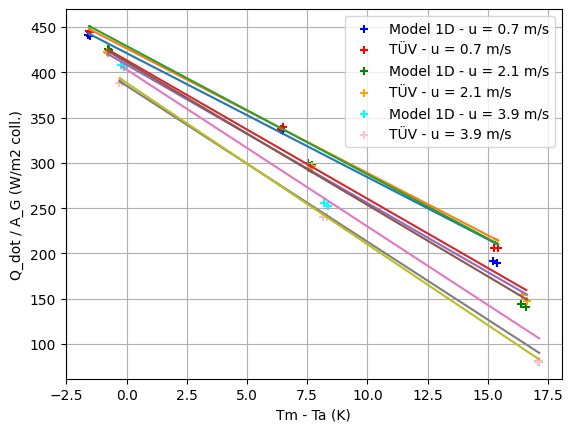

In [98]:
# u_list = [0.7,2.1,3.9]
u_list = [0.7,2.1,3.9]

color_list = ['blue','red','green','orange','cyan','pink']

for i in range(len(u_list)):

    plt.scatter(-df_res.loc[df_res["u"]==u_list[i]]['-(T_m - T_a)'],df_res.loc[df_res["u"]==u_list[i]]['Q_dot / A_G'],marker="+",color=color_list[2*i],label='Model 1D - u = '+str(u_list[i])+' m/s')
    plt.scatter(condi_output.loc[condi_output["u"]==u_list[i]]['tm-ta'],condi_output.loc[condi_output["u"]==u_list[i]]['Q_dot / A_G'],marker='+',color=color_list[2*i+1],label='TÜV - u = '+str(u_list[i])+' m/s')

    plt.plot(-df_res.loc[df_res["u"]==u_list[i]]['-(T_m - T_a)'],df_res.loc[df_res["u"]==u_list[i]]['SK_power'])
    plt.plot(condi_output.loc[condi_output["u"]==u_list[i]]['tm-ta'],condi_output.loc[condi_output["u"]==u_list[i]]['SK_power'])

    plt.plot(condi_output.loc[condi_output["u"]==u_list[i]]['tm-ta'],condi_output.loc[condi_output["u"]==u_list[i]]['TUV_power'])

    # plt.plot(condi_39['tm-ta'], fitLine, c='r')

    # plt.plot(condi_39['tm-ta'], fitLine2, c='g')

plt.xlabel('Tm - Ta (K)')
plt.ylabel('Q_dot / A_G (W/m2 coll.)')

plt.grid()
plt.legend()
plt.show()


In [49]:
from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(condi_39['tm-ta'], condi_39['Q_dot / A_G'])

In [50]:
def predict(x):
   return slope * x + intercept

In [68]:
def predictp(x):
    return -17.55 * x + 0.384*1000

In [52]:
fitLine = predict(condi_39['tm-ta'])

In [69]:
fitLine2 = predictp(condi_39['tm-ta'])

In [28]:
pr.display_a_i(SK_condi_output)

eta0,hem  :  0.396
a1  :  16.238
a2  :  0.0
a3  :  1.082
a4  :  0.0
a6  :  0.013
a7  :  0.0
41.8 %
14.4


In [ ]:
# Epaisseur d'ailette

par["Heta"] = 0.020
par["L_f0"] = 0.020
par["D"] = 0.014

k_list = [0.2,0.5,1,30,100,237]

Lf0_list = [0.0001,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050]

lambd_list = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010]

for ki in range(len(k_list)):

    par["k_ail"] = k_list[ki]

    A0 = []
    A1 = []
    a3 = []

    f0_area = []

    for i in range(len(lambd_list)):
        # R_INTER = par["R_INTER"]
        # old_R_abs = par["lambd_abs"]/par["k_abs"]
        # par["lambd_abs"]=test_list[i]
        # new_R_abs = par["lambd_abs"]/par["k_abs"]
        # par["R_INTER"] = R_INTER - old_R_abs + new_R_abs
        

        # par["Heta"] = Lf0_list[i]
        # par["L_f0"] = Lf0_list[i]


        par["lambd_ail"] = lambd_list[i]

        par["N_ail"] = round((par["D"]+par["w_abs"])/(par["D"]+par["lambd_ail"]))
        par["N_f0"] = round(par["N_ail"]*par["L_riser"]/par["w_abs"])


        df_par,df_res,X,list_df,list_df_historic = ty.simu_condi(par,condi)
        A0.append(pr.A0_A1(X)[0])
        A1.append(pr.A0_A1(X)[1])
        a3.append(round(X[0][3],3))
        f0_area.append(float(df_par.loc["w_abs"])*float(df_par.loc["N_f0"])*float(df_par.loc["L_f0"]))

    plt.scatter(np.array(lambd_list)*1000,np.array(A1),marker="o",label="k_fin = "+str(par["k_ail"]))

plt.xlabel('Fin thickness (mm)')
plt.ylabel('A1 (1,3 m/s)')
plt.legend()
plt.show()


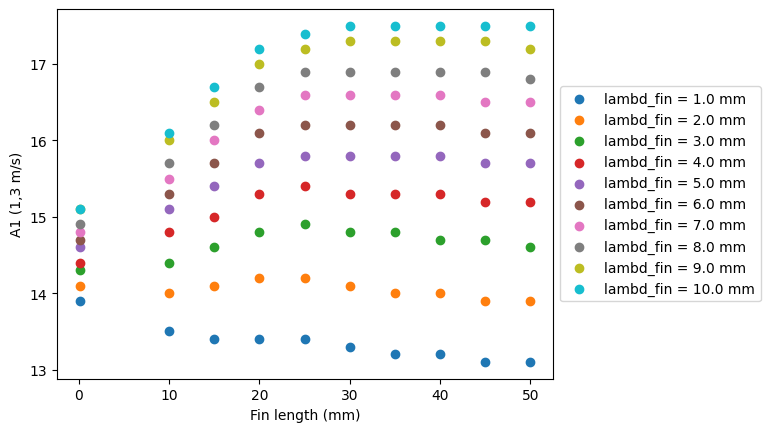

In [26]:
# Epaisseur et longueur ailette

par["k_ail"] = 0.5
par["D"] = 0.014

# par["D"] = (par["w_abs"]-par["N_ail"]*par["lambd_ail"])/(par["N_ail"]-1)

Lf0_list = [0.0001,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050]

lambd_list = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010]

for ki in range(len(lambd_list)):

    par["lambd_ail"] = lambd_list[ki]

    par["N_ail"] = round((par["D"]+par["w_abs"])/(par["D"]+par["lambd_ail"]))
    par["N_f0"] = round(par["N_ail"]*par["L_riser"])/par["w_abs"]

    A0 = []
    A1 = []
    a3 = []

    f0_area = []

    for i in range(len(Lf0_list)):
        # R_INTER = par["R_INTER"]
        # old_R_abs = par["lambd_abs"]/par["k_abs"]
        # par["lambd_abs"]=test_list[i]
        # new_R_abs = par["lambd_abs"]/par["k_abs"]
        # par["R_INTER"] = R_INTER - old_R_abs + new_R_abs
        

        par["Heta"] = Lf0_list[i]
        par["L_f0"] = Lf0_list[i]


        df_par,df_res,X,list_df,list_df_historic = ty.simu_condi(par,condi)
        A0.append(pr.A0_A1(X)[0])
        A1.append(pr.A0_A1(X)[1])
        a3.append(round(X[0][3],3))
        f0_area.append(float(df_par.loc["w_abs"])*float(df_par.loc["N_f0"])*float(df_par.loc["L_f0"]))

    plt.scatter(np.array(Lf0_list)*1000,np.array(A1),marker="o",label="lambd_fin = "+str(par["lambd_ail"]*1000)+" mm")

plt.xlabel('Fin length (mm)')
plt.ylabel('A1 (1,3 m/s)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

55


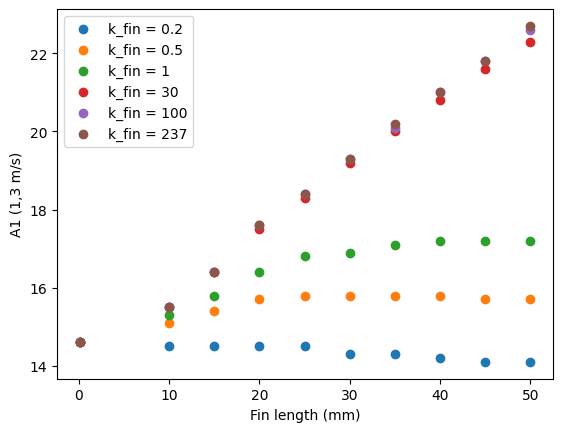

In [20]:
# Conductivité et longueur ailette

par["lambd_ail"] = 0.005
par["D"] = 0.014
par["N_ail"] = round((par["D"]+par["w_abs"])/(par["D"]+par["lambd_ail"]))
par["N_f0"] = round(par["N_ail"]*par["L_riser"])/par["w_abs"]
# par["D"] = (par["w_abs"]-par["N_ail"]*par["lambd_ail"])/(par["N_ail"]-1)
print(par["N_ail"])

k_list = [0.2,0.5,1,30,100,237]

Lf0_list = [0.0001,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050]

lambd_list = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010]

for ki in range(len(k_list)):

    par["k_ail"] = k_list[ki]

    A0 = []
    A1 = []
    a3 = []

    f0_area = []

    for i in range(len(Lf0_list)):
        # R_INTER = par["R_INTER"]
        # old_R_abs = par["lambd_abs"]/par["k_abs"]
        # par["lambd_abs"]=test_list[i]
        # new_R_abs = par["lambd_abs"]/par["k_abs"]
        # par["R_INTER"] = R_INTER - old_R_abs + new_R_abs
        

        par["Heta"] = Lf0_list[i]
        par["L_f0"] = Lf0_list[i]


        df_par,df_res,X,list_df,list_df_historic = ty.simu_condi(par,condi)
        A0.append(pr.A0_A1(X)[0])
        A1.append(pr.A0_A1(X)[1])
        a3.append(round(X[0][3],3))
        f0_area.append(float(df_par.loc["w_abs"])*float(df_par.loc["N_f0"])*float(df_par.loc["L_f0"]))

    plt.scatter(np.array(Lf0_list)*1000,np.array(A1),marker="o",label="k_fin = "+str(par["k_ail"]))

plt.xlabel('Fin length (mm)')
plt.ylabel('A1 (1,3 m/s)')
plt.legend()
plt.show()

In [18]:
areas = {"fs_he_area" : float(df_par.loc["A_G"]),"bs_he_area" : float(df_par.loc["w_abs"])*float(df_par.loc["L_abs"]),"f0_area" : float(df_par.loc["w_abs"])*float(df_par.loc["N_f0"])*float(df_par.loc["L_f0"])}

In [19]:
areas

{'fs_he_area': 1.9368719999999997,
 'bs_he_area': 1.38422,
 'f0_area': 1.8760000000000003}

In [15]:
backside_he_area

1.38422

In [21]:
# Air layer

test_list = np.linspace(0.001,0.002,30)



A0 = []
A1 = []
a1 = []
a3 = []

for i in range(len(test_list)):
    ty.change_air_layer(par,test_list[i])
    df_par,df_res,X,list_df,list_df_historic = ty.simu_condi(par,condi)
    A0.append(pr.A0_A1(X)[0])
    A1.append(pr.A0_A1(X)[1])
    a1.append(round(X[0][1],3))
    a3.append(round(X[0][3],3))

In [ ]:
plt.plot(test_list,A0)
plt.show()

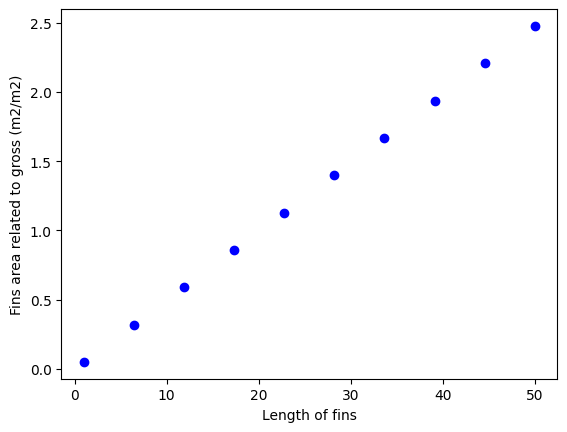

In [110]:
plt.scatter(np.array(test_list)*1000,np.array(f0_area)/float(df_par.loc["A_G"]),marker="o",color='blue')
plt.xlabel('Length of fins')
plt.ylabel('Fins area related to gross (m2/m2)')
plt.show()

In [8]:
# Glass

test_list = np.linspace(0.001,0.010,20)

A0 = []
A1 = []

for i in range(len(test_list)):
    R_TOP = par["R_TOP"]
    old_R_glass = par["lambd_glass"]/par["k_glass"]
    par["lambd_glass"]=test_list[i]
    new_R_glass = par["lambd_glass"]/par["k_glass"]
    par["R_TOP"] = R_TOP - old_R_glass + new_R_glass
    df_par,df_res,X,list_df,list_df_historic = ty.simu_condi(par,condi)
    A0.append(pr.A0_A1(X)[0])
    A1.append(pr.A0_A1(X)[1])

In [6]:
df_res["-Q_top_conv"]=-df_res["Q_top_conv"]
df_res["-Q_top_rad"]=-df_res["Q_top_rad"]

In [ ]:
display(HTML(df_par.to_html()))

In [32]:
bht.Nu_forced_flat_plate_isoflux_lam(1.5, 0.024,3,15.6*10**(-6),0.707)

3.4679163530369324

In [36]:
(1/1.5)*integrate.quad(bht.Nu_forced_flat_plate_isoflux_lam,0,1.5,args=(0.024,3.,15.6*10**(-6),0.707))[0]

6.935832706073858

In [38]:
bht.h_top_forced(300,290,2.7,1.5)

7.159675344181611

In [23]:
1/(263*df_par.loc['p_tube'])+1/df_par.loc['C_B']

0    0.50453
dtype: object

In [22]:
1/(df_par.loc['p_tube']/(1/263+1/df_par.loc['C_B']))

0    0.535658
dtype: object

In [24]:
1/1.468

0.6811989100817439

In [4]:
300*(df_res["Q_fluid1"]-(df_res["Q_PV_plate"]-df_res["Q_fluid_back"]-df_res["Q_f01"]))

0      0.243539
1      0.256120
2      0.276687
3      0.299775
4      0.378408
5      0.369860
6     -3.045364
7     -3.116111
8     -4.576613
9     -4.571511
10    -6.423752
11    -6.315078
12   -10.705642
13   -10.813524
14   -14.541782
15   -14.482845
16   -18.977397
17   -18.990824
dtype: float64

In [22]:
float(df_par.loc["W"])*float(df_par.loc["L_riser"])*df_res["S"]

0     1036.530846
1     1036.558795
2     1036.331496
3     1036.325198
4     1036.050097
5     1035.993584
6     1043.472324
7     1043.439404
8     1042.866181
9     1042.841035
10    1042.174024
11    1042.206979
12    1049.935446
13    1049.925173
14    1049.055904
15    1049.090970
16    1048.050914
17    1048.034831
Name: S, dtype: float64

In [5]:
(float(df_par.loc["W"])*float(df_par.loc["L_riser"])*df_res["S"]-df_res["Q_top_conv"]-df_res["Q_top_rad"])-df_res["Q_PV_plate"]

0     9.288570e-11
1    -4.435168e-10
2    -2.526797e-10
3    -2.519842e-10
4    -1.182698e-11
5    -9.123813e-12
6     2.158496e-11
7     5.175060e-11
8     8.092194e-12
9    -5.131451e-12
10   -1.856293e-12
11   -1.792966e-11
12    2.714869e-09
13    1.235804e-08
14    6.078187e-10
15    3.013014e-10
16    1.856271e-11
17    7.666978e-12
dtype: float64

In [89]:
((((float(df_par.loc["W"])*float(df_par.loc["L_riser"])*df_res["S"]-df_res["Q_top_conv"]-df_res["Q_top_rad"])-df_res["Q_fluid_back"]-df_res["Q_f01"])-df_res["Q_fluid1"])*300)/(df_res["Q_fluid1"]*300)

0    -0.000241
1    -0.000253
2    -0.000287
3    -0.000313
4    -0.000413
5    -0.000406
6     0.003963
7     0.004076
8     0.006688
9     0.006679
10    0.010848
11    0.010578
12    0.023381
13    0.023870
14    0.043699
15    0.043211
16    0.095523
17    0.095833
dtype: float64

In [8]:
df_select_u = df_res.loc[df_res["u"]<=1.]

In [26]:
display(HTML(df_select_u.to_html()))

,G,-(T_m - T_a),-(T_m - T_a)^2,-up x (T_m - T_a),Gp,up x G,up x Gp,-(T_m - T_a)^4,m_dot,Gp,T_amb,u,h_top,h_back,h_fluid,T_PV,T_fluid_in,h_rad,X_celltemp,eta_PV,S,T_fluid_out,qp_fluid,T_fluid_mean,T_Base_mean,T_fin_mean,T_abs_mean,T_PV_meanB,qp_PV_Base,qp_Base_back,qp_fin,Q_top_conv,Q_top_rad,Q_PV_plate,Q_abs_back,Q_PV_Base,Q_Base_back,Q_fluid1,Q_fluid2,Q_absfins_Base,Q_fluid_back,Q_f01,qp_f0,DT,T_m,T_m en °C,c_p(T),Q_dot,Q_dot / A_G,S_loc,-Q_fluid_back,-Q_f01,-Q_top_conv,-Q_top_rad
0,988,2.869697,-8.235159,-6.313333,4,2173.6,8.8,-67.817842,0.03970,4,301.922,0.8,6.319140,0.499729,263.498875,304.898662,296.262,5.719445,0.977055,0.195411,635.947217,301.842607,2.103374,299.107054,301.456389,301.456393,301.456389,304.898662,2.054628,0.0,0.013098,0.092369,0.067590,3.054636,-0.000007,3.016194,0.0,3.087754,3.087754,0.038456,-0.006961,-0.024785,-0.017030,5.580607,299.052303,25.902303,4181.113635,926.326085,478.258803,3.214594,0.006961,0.024785,-0.092369,-0.067590
1,988,3.005922,-9.035569,-6.613029,4,2173.6,8.8,-81.641515,0.03969,4,302.075,0.8,6.314310,0.499729,263.498875,304.930662,296.270,5.724636,0.976946,0.195389,635.964416,301.868155,2.109453,299.124017,301.480141,301.480145,301.480141,304.930662,2.059551,0.0,0.013131,0.088548,0.064178,3.061955,-0.000009,3.023421,0.0,3.096677,3.096677,0.038553,-0.007297,-0.025983,-0.017853,5.598155,299.069078,25.919078,4181.105669,929.003131,479.640953,3.214681,0.007297,0.025983,-0.088548,-0.064178
6,988,-5.560189,-30.915703,12.232416,4,2173.6,8.8,-955.780695,0.04183,4,302.497,0.8,6.586090,1.638238,263.498875,312.871746,306.002,5.965606,0.949946,0.189989,640.232526,310.112378,1.631369,308.111303,309.933438,309.933441,309.933438,312.871746,1.753821,0.0,0.010912,0.335136,0.293697,2.607423,0.000387,2.574609,0.0,2.394849,2.394849,0.032039,0.044645,0.158135,0.110765,4.110378,308.057189,34.907189,4178.589827,718.454708,370.935564,3.236256,-0.044645,-0.158135,-0.335136,-0.293697
7,988,-5.696089,-32.445429,12.531396,4,2173.6,8.8,-1052.705860,0.04192,4,302.343,0.8,6.590459,1.638238,263.498875,312.835340,305.999,5.960140,0.950070,0.190014,640.212959,310.079178,1.622867,308.092687,309.905326,309.905329,309.905326,312.835340,1.748870,0.0,0.010876,0.339153,0.296942,2.600062,0.000394,2.567341,0.0,2.382369,2.382369,0.031933,0.045722,0.161948,0.113436,4.080178,308.039089,34.889089,4178.591812,714.710751,369.002573,3.236157,-0.045722,-0.161948,-0.339153,-0.296942
12,988,-14.049205,-197.380175,30.908252,4,2173.6,8.8,-38958.933390,0.04216,4,302.748,0.8,6.813616,2.325087,263.498875,320.305663,315.611,6.194637,0.924671,0.184934,644.228049,317.983411,0.949054,316.833661,317.893694,317.893696,317.893694,320.305663,1.439659,0.0,0.008411,0.586158,0.529939,2.140355,0.001120,2.113419,0.0,1.393211,1.393211,0.024696,0.157176,0.554974,0.393172,2.372411,316.797205,43.647205,4178.763166,417.963429,215.793005,3.256453,-0.157176,-0.554974,-0.586158,-0.529939
13,988,-14.193647,-201.459615,31.226023,4,2173.6,8.8,-40585.976548,0.04217,4,302.614,0.8,6.817830,2.325087,263.498875,320.294838,315.635,6.190416,0.924708,0.184942,644.222233,317.980294,0.938429,316.843677,317.891842,317.891845,317.891842,320.294838,1.434303,0.0,0.008371,0.590624,0.533406,2.132393,0.001130,2.105557,0.0,1.377614,1.377614,0.024576,0.158783,0.560648,0.397192,2.345294,316.807647,43.657647,4178.764577,413.284196,213.377134,3.256423,-0.158783,-0.560648,-0.590624,-0.533406


In [9]:
df_hist = df_select_u

dict_pos = {}
dict_neg = {}
dict_pos_agg = {}
dict_neg_agg = {}

DT_list = []
for DT in df_hist["-(T_m - T_a)"]:
    DT_list.append(-DT)

powers = ["S_loc","-Q_top_conv","-Q_top_rad","-Q_fluid_back"]
# powers = ["S_loc","-Q_top_conv","-Q_top_rad","-Q_fluid_back","-Q_f01"]


for i in range(len(powers)):
    str = powers[i]
    
    dict_pos[str] = 300*np.array(ty.pos_df(df_hist,str))
    dict_neg[str] = 300*np.array(ty.neg_df(df_hist,str))

    if i==0:
        dict_pos_agg[str] = 0*np.array(ty.pos_df(df_hist,str))
        dict_neg_agg[str] = dict_pos_agg[str]

    else:
        dict_pos_agg[str] = dict_pos_agg[powers[i-1]] + dict_pos[powers[i-1]]
        dict_neg_agg[str] = dict_neg_agg[powers[i-1]] + dict_neg[powers[i-1]]

In [13]:
dict_pos["S_loc"]

array([964.37834133, 964.40442247, 970.87677282, 970.84710027,
       976.93575935, 976.92693937])

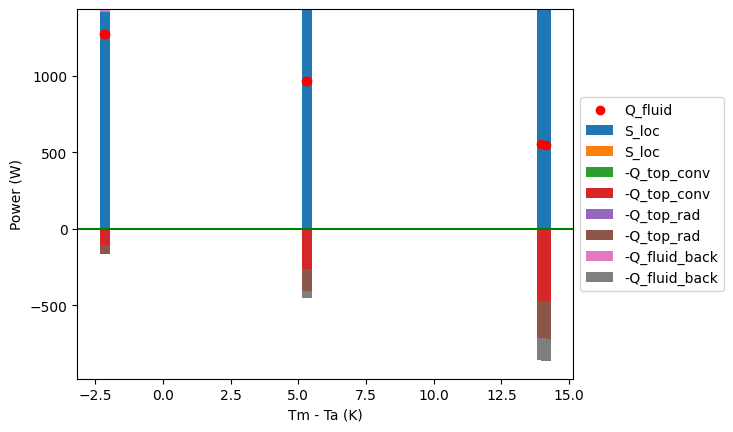

In [10]:
fig, ax = plt.subplots()

width = 0.35

for str in powers:
    ax.bar(DT_list, dict_pos[str], width, bottom=dict_pos_agg[str], label=str)
    ax.bar(DT_list, dict_neg[str], width, bottom=dict_neg_agg[str], label=str)

ax.scatter(DT_list,300*df_hist["Q_fluid1"],color="red",label="Q_fluid")
# ax.plot(labels,np.array(N_disp*[list_PL[q]]))

# ax.set_ylabel('PL (Pa)')
# ax.set_title('SPRING')
ax.set_xlabel("Tm - Ta (K)")
ax.set_ylabel("Power (W)")
ax.axhline(y = 0., color = 'g', linestyle = '-')
  
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

0     3.282415
1     3.291289
2     3.179601
3     3.172675
4     3.048628
5     3.035023
6     2.561932
7     2.548906
8     2.281031
9     2.281806
10    1.974028
11    1.990134
12    1.526263
13    1.510101
14    1.109245
15    1.117238
16    0.662233
17    0.660558
Name: Q_fluid1, dtype: float64

In [58]:
df_res["Q_PV_plate"]+df_res["Q_top_conv"]+df_res["Q_top_rad"]

0     3.455107
1     3.455200
2     3.454441
3     3.454420
4     3.453501
5     3.453305
6     3.478242
7     3.478133
8     3.476221
9     3.476138
10    3.473914
11    3.474024
12    3.499785
13    3.499751
14    3.496853
15    3.496970
16    3.493503
17    3.493449
dtype: float64

In [ ]:
tab_mat

In [24]:
pr.display

(array([2.49466354e-01, 2.49466354e-01, 2.09908533e+01, 1.27461825e-01,
        1.75642102e+00, 1.00998524e-03, 1.00998524e-03, 8.32522450e-03,
        3.37053624e-05, 5.14674345e-05]),
 array([], dtype=float64),
 6,
 array([1.25471876e+05, 6.60325724e+03, 3.56962580e+03, 6.91415616e+01,
        3.04326290e+01, 4.40571418e+00, 2.41152654e-12, 2.32103811e-15,
        6.35407134e-16, 4.11726819e-17]))

In [11]:
X[0][len(X[0])-1]

5.146743445281446e-05

In [ ]:
# Test complet TUV ou général (key word: wing)

### Creating Excel outputs

if par["test"] == "TUV":
    prefixe = r'\OutputsTUV'
else: # general
    prefixe = r'\Parametric'

suffixe = prefixe+str(par["ailette"])+r'-'+moment+r'.xlsx'
fichier_o = pathout+suffixe

for d in dataframe_to_rows(df_par, index=True, header=False):
    sheet_o.append(d)

wso = wbo.create_sheet("Outputs")

for d in dataframe_to_rows(df, index=True, header=True):
    wso.append(d)

huit = len(X[0])-1

index_coeff = ['a1','a2','a3','a4','a6','a7','a8']
ws_lsm = wbo.create_sheet("LSM")
ws_lsm['A'+str(1)] = 'a0'
ws_lsm['B'+str(1)] = X[0][len(X[0])-1]

print('a0 : ',round(X[0][len(X[0])-1],3))

ws_lsm['C'+str(1)] = X[3][len(X[0])-1]
for l in range(huit):
    ws_lsm['A'+str(l+2)] = index_coeff[l]
    if l != 3:
        ws_lsm['B'+str(l+2)] = -X[0][l]
        print(index_coeff[l],' : ',round(-X[0][l],3))

    else:
        ws_lsm['B'+str(l+2)] = X[0][l]
        print(index_coeff[l],' : ',round(X[0][l],3))

    ws_lsm['C'+str(l+2)] = X[3][l]

ws_lsm['A'+str(huit+2)] = 'a0 (DS) at 1,3 m/s'
ws_lsm['B'+str(huit+2)] = X[0][len(X[0])-1] - (-X[0][4]*(1.3-3))
print(round(X[0][len(X[0])-1] - (-X[0][4]*(1.3-3)),3)*100,'%')

ws_lsm['A'+str(huit+3)] = 'a1 (DS) at 1,3 m/s'
ws_lsm['B'+str(huit+3)] = -X[0][0] - X[0][2]*(1.3-3)
print(round(-X[0][0] - X[0][2]*(1.3-3),1))
    
wbo.save(filename = fichier_o)
wbo.close()

### Excel is created

print(df)

print("Finished")

In [5]:
al = pd.DataFrame([[1,2,3],[2,3,4],[4,5,6]],columns=['a','b','c'])

In [7]:
al.keys()[0]

'a'

In [23]:
df

,N_test,T_guess,G,Gp,T_amb,u,T_abs,T_fluid_in,T_fluid_out,h_back,...,Q_PV_plate,Q_abs_back,Q_PV_Base,Q_Base_back,Q_fluid1,Q_fluid2,Q_absfins_Base,Q_fluid_back,power_balance_1,power_balance_3
0,0.0,299.1725,988.0,4.0,302.075,0.8,299.097457,296.270,301.486119,1.111486,...,54.547404,-0.160631,5.641052,0.0,54.163637,54.163637,48.404279,-0.093304,-2.662116e-09,-0.025002
1,1.0,298.7730,988.0,4.0,301.248,2.1,299.240631,296.298,301.369149,0.925971,...,53.392547,-0.099730,5.535036,0.0,52.658284,52.658284,47.044738,-0.061832,-6.109468e-10,-0.016679
2,2.0,298.7260,988.0,4.0,301.142,2.1,299.286733,296.310,301.365708,0.886760,...,53.230746,-0.090595,5.523160,0.0,52.497945,52.497945,46.902336,-0.057064,9.213963e-12,-0.015385
3,3.0,298.4070,988.0,4.0,300.497,3.7,299.288929,296.317,301.228795,0.803352,...,52.018417,-0.057756,5.403102,0.0,50.990717,50.990717,45.537378,-0.039491,1.360929e-10,-0.010746
4,4.0,298.3030,988.0,4.0,300.320,3.7,299.273281,296.286,301.176378,0.776465,...,51.810544,-0.050659,5.385333,0.0,50.781176,50.781176,45.350668,-0.035514,6.232654e-10,-0.009661
5,5.0,304.2495,988.0,4.0,302.497,0.8,307.569051,306.002,309.916745,1.349511,...,47.354700,0.269561,4.843043,0.0,42.842084,42.842084,38.216627,0.171521,2.024239e-10,0.046065
6,6.0,304.1710,988.0,4.0,302.343,0.8,307.505255,305.999,309.883466,1.381843,...,47.268821,0.279907,4.830056,0.0,42.602176,42.602176,37.999323,0.179089,1.385265e-10,0.048114
7,7.0,303.6895,988.0,4.0,301.370,2.1,307.188824,306.009,309.608414,1.473571,...,45.059389,0.334967,4.566060,0.0,39.447670,39.447670,35.159206,0.218371,8.718448e-11,0.059225
8,8.0,303.6625,988.0,4.0,301.347,2.1,307.155908,305.978,309.579033,1.475851,...,45.070087,0.334696,4.566911,0.0,39.455992,39.455992,35.166568,0.218286,9.809487e-12,0.059202
9,9.0,303.2215,988.0,4.0,300.448,3.7,306.810559,305.995,309.256708,1.562970,...,42.382295,0.386708,4.242596,0.0,35.755131,35.755131,31.839615,0.256685,-1.014122e-11,0.070395


In [25]:
dfbis = df.loc[df['u']==0.7]

In [20]:
dfbis

NameError: name 'dfbis' is not defined

In [ ]:
# Parametric study

N_list = np.linspace(40,120,10)

test_list = []
test_list = N_list

# for i in range(len(D_list)):
#     test_list.append(math.floor((D_list[i]+par["w_abs"])/(D_list[i]+par["lambd_ail"])))


# test_list = np.linspace(25,125,20)

A0 = []
A1 = []
A2 = []
A3 = []
A4 = []
A6 = []
A7 = []
A8 = []

for i in range(len(test_list)):

    pr.proc(par,par["test"],i,test_list)

    # Model
    # if 'TUV' in par["test"]:
    #     df_par,df,X = ty.simu_condi(par,condi)
    # else:
    #     df_par,df,X = ty.simu_multi_condi(par,G_list,coeff_Gp_list,T_amb_list,u_list,T_guess_list,T_f_in_list)

    df_par,df,X = ty.simu_condi(par,condi)

    A0.append(X[0][len(X[0])-1])
    A1.append(-X[0][0])
    A2.append(-X[0][1])
    A3.append(-X[0][2])
    A4.append(X[0][3])
    A6.append(-X[0][4])
    A7.append(-X[0][5])
    A8.append(-X[0][6])

# Creating Excel outputs

suffixe = r'\Parametric'+str(par["ailette"])+r'-'+moment+r'.xlsx'
fichier_o = pathout+suffixe

for d in dataframe_to_rows(df_par, index=True, header=False):
    sheet_o.append(d)

wso = wbo.create_sheet("Outputs")

wso['A'+str(1)] = par["test"]
wso['B'+str(1)] = 'a0'
wso['C'+str(1)] = 'a1'
wso['D'+str(1)] = 'a2'
wso['E'+str(1)] = 'a3'
wso['F'+str(1)] = 'a4'
wso['G'+str(1)] = 'a6'
wso['H'+str(1)] = 'a7'
wso['I'+str(1)] = 'a8'
wso['J'+str(1)] = 'a0 DS'
wso['K'+str(1)] = 'a1 DS'

A0DS = []
A1DS = []

for l in range(len(test_list)):
    wso['A'+str(l+2)] = test_list[l]
    wso['B'+str(l+2)] = A0[l]
    wso['C'+str(l+2)] = A1[l]
    wso['D'+str(l+2)] = A2[l]
    wso['E'+str(l+2)] = A3[l]
    wso['F'+str(l+2)] = A4[l]
    wso['G'+str(l+2)] = A6[l]
    wso['H'+str(l+2)] = A7[l]
    wso['I'+str(l+2)] = A8[l]
    wso['J'+str(l+2)] = A0[l]-A6[l]*(-1.7)
    wso['K'+str(l+2)] = A1[l]+A3[l]*(-1.7)

    A0DS.append(A0[l]-A6[l]*(-1.7))
    A1DS.append(A1[l]+A3[l]*(-1.7))

wbo.save(filename = fichier_o)
wbo.close()

print("Finished")

In [ ]:
print(test_list)

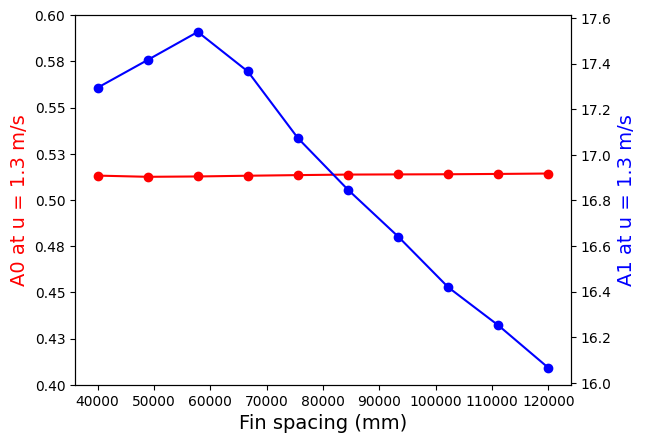

In [16]:
# Plot parametric study

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot

ax.plot(np.array(test_list)*1000,A0DS,
        color="red", 
       marker="o")

# set x-axis label

ax.set_xlabel("Fin spacing (mm)", fontsize = 14)

# set y-axis label

ax.set_ylabel("A0 at u = 1.3 m/s",
              color="red",
              fontsize=14)

ax.set_ybound(0.4,0.6)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.1f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# ax.axhline(y = 0.999*0.396177,label='98% of the maximum performance',color='green')
# ax.axvline(x = 0.4, label = 'Thickness of the tested prototype',color='black')
# ax.axhline(y = 0.394,color='black')
# ax.axvline(x = 1.3,color='green')
# ax.legend()

# twin object for two dif       ferent y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(np.array(test_list)*1000,A1DS,color="blue",marker="o")
ax2.set_ylabel("A1 at u = 1.3 m/s",color="blue",fontsize=14)

# ax2.set_ybound(12.5,16)

# save the plot as a file
plt.savefig('parametric.png',format='png',dpi=200,bbox_inches='tight')

plt.show()

In [ ]:
a = {'a' : 1, 'b' : 2}
b = {'a' : 2, 'b' : 4}
l = [a,b]
dfl = pd.DataFrame(l)
dfm = dfl.mean()
print(dfl)
print(dfm)
print(dfm['a'])

dfh = pd.DataFrame([dfm,dfm,dfm])
print(dfh)

bonjour = 'a'
print(dfh[bonjour])

In [ ]:
print(test_list)
print(A0DS[5])

In [ ]:
np.max(A0DS)

In [ ]:
par["h_fluid"]

In [ ]:
# Test d'un panneau dans un set de conditions donné (résultats en détails tranche par tranche)

suffixe = r'\OnePanel-'+moment+r'.xlsx'
fichier_o = pathout+suffixe
var = {}

list_var,list_var_conv = ty.simu_one_steady_state(par,var,par["N_meander"],par["T_fluid_in0"],315,"all")

compt = 2

*var_names0, = var
var_names = ['T_fluid_in'] + var_names0

for m in range(len(var_names)):
    sheet_o.cell(row=1,column=m+1,value = var_names[m])

for l in range(par["N_meander"]):
    for m in range(len(var_names)):
        sheet_o.cell(row=l+2,column=m+1,value = list_var[l][var_names[m]])

sheet_o3 = wbo.create_sheet("Convergence")

var_names2 = ['Slice','T_fluid_in'] + var_names0

for m in range(len(var_names2)):
    sheet_o3.cell(row=1,column=m+1,value = var_names2[m])

for l in range(len(list_var_conv)):
    for m in range(len(var_names2)):
        sheet_o3.cell(row=l+2,column=m+1,value = list_var_conv[l][var_names2[m]])


sheet_o2 = wbo.create_sheet("T_abs")

x_list = np.linspace(0,par["delta"],100)

T_abs = []

delta = par["delta"]

for k in range(par["N_meander"]):
    b = list_var[k]["b"]
    j = list_var[k]["j"]
    m = list_var[k]["m"]
    T_B = list_var[k]["T_Base_mean"]

    b_j = b/j

    for l in range(len(x_list)):
        res = b_j+((T_B-b_j)/math.cosh(m*delta))*math.cosh(m*x_list[l])

        sheet_o2.cell(row=l+1,column=k+2,value = res)

for l in range(len(x_list)):
    sheet_o2.cell(row=l+1,column=1,value=x_list[l])

wbo.save(filename = fichier_o)
wbo.close()

print("Finished")

In [44]:
hein = {'ah':1,'bh':2}
print(hein.values())
print(hein.keys())
hh = pd.DataFrame.from_dict({'row' : hein.values()},orient='index',columns=hein.keys())

dict_values([1, 2])
dict_keys(['ah', 'bh'])


In [47]:
"main" in ["mai","bonjour"]

False

In [48]:
yoo = pd.DataFrame()

In [51]:
yoo['salut'] = [2]

In [52]:
yoo

,salut
0,2
